In [ ]:
# Utilities

In [294]:
import numpy as np

def get_cdf_xy(arr: np.array):
    values, counts = np.unique(arr, return_counts=True)
    y = np.cumsum(counts) / np.sum(counts)
    return values, y


In [295]:
# Configure Model and Trace Specifications


In [296]:
# fill these in before starting
# these specs are for Qwen 30B
GB_per_tok = 0.00009150208
# these specs are for a jsonl trace of the format
# {"timestamp": "1753825690492790285", "input_length": 1296, "output_length": 436, "hash_ids": [1943776520, 3719818480, 1374022796, 2572552414, 3858544305, 813100772, 921022818, 3291968017, 3616750900, 747068305, 2139209936, 2431468410, 505121230, 2014299782, 3641269950, 2935719212, 1310587723, 3615619246, 684199143, 2865734127, 3569072129, 715014960, 3968411579, 3277477938, 3625461172, 3973057607, 3788817391, 4133828466, 810718364, 1495344022, 3284209704, 1987224378, 899414564, 1550958486, 1285110896, 1002106162, 270882012, 38297527, 1920286917, 2500114121, 2312101374]}
# where each hash id represents 32 tokens
toks_per_hash = 32


In [297]:
# Loading and Pre-Processing


In [298]:
# change if needed
trace_file_name = "flow_gpt_trace.jsonl"

import pandas as pd
df = pd.read_json(trace_file_name, lines=True)

print(df.head())


                      timestamp  input_length  output_length  \
0 2024-12-23 05:26:23.185372160          2278              1   
1 2024-12-23 05:26:23.518704896          1653              1   
2 2024-12-23 05:26:23.852037888           227              1   
3 2024-12-23 05:26:24.185370880           227              1   
4 2024-12-23 05:26:24.518703872           227              1   

                                            hash_ids  
0  [3154513355, 1642929395, 2603131884, 188902857...  
1  [3154513355, 1642929395, 2603131884, 188902857...  
2  [3154513355, 1642929395, 2603131884, 188902857...  
3  [3154513355, 1642929395, 2603131884, 188902857...  
4  [3154513355, 1642929395, 2603131884, 188902857...  


In [299]:
import hashlib

# make sure the function that was used to hash the tokens into hash_ids was done in a prefix manner (or else we could see non-prefix reuse)
def rehash(hash_ids: list[int]) -> list[int]:
    curr_hash = hash_ids[0]
    ret = [curr_hash]
    for hash_id in hash_ids[1:]:
        curr_hash = hashlib.sha256(f"{curr_hash}{hash_id}".encode()).hexdigest()
        curr_hash = int(curr_hash, 16) % 1_000_000_007
        ret.append(curr_hash)
    return ret

df["hash_ids"] = df["hash_ids"].apply(rehash)

print(df.head())


                      timestamp  input_length  output_length  \
0 2024-12-23 05:26:23.185372160          2278              1   
1 2024-12-23 05:26:23.518704896          1653              1   
2 2024-12-23 05:26:23.852037888           227              1   
3 2024-12-23 05:26:24.185370880           227              1   
4 2024-12-23 05:26:24.518703872           227              1   

                                            hash_ids  
0  [3154513355, 362218388, 986937974, 47003040, 6...  
1  [3154513355, 362218388, 986937974, 47003040, 6...  
2  [3154513355, 362218388, 986937974, 47003040, 6...  
3  [3154513355, 362218388, 986937974, 47003040, 6...  
4  [3154513355, 362218388, 986937974, 47003040, 6...  


In [300]:
# Slicing out the best part of the trace (highest reuse)
# this can be done before cloning to ensure: 
# 1. high reuse
# 2. high CPU hit rate (requires "exploding" the GPU buffer)

In [301]:
# Calculate average input and output length in order to help make an educated decision about window size
avg_input_length = df["input_length"].mean()
avg_output_length = df["output_length"].mean()
print(f"Average input length: {avg_input_length}")
print(f"Average output length: {avg_output_length}")

Average input length: 3587.6126
Average output length: 1.0


In [302]:
from collections import defaultdict

# Configure window_size_toks
# number of tokens we want in our window
window_size_toks = 50000
window_size_hashes = window_size_toks / toks_per_hash

# l inclusive, r exclusive
l, r = 0, 0
cur_hashes = defaultdict(int)
cur_reuse = 0
# cur_hash_count counts repititions
cur_hash_count = 0
max_l, max_r = 0, 0
max_reuse = 0
max_window_size = 0
max_hash_count = 0
while r < len(df): 
    next_req = df.iloc[r]
    while r < len(df) and cur_hash_count < window_size_hashes:
        next_req = df.iloc[r]
        for hash_id in next_req["hash_ids"]:
            if hash_id in cur_hashes:
                cur_reuse += 1
            cur_hashes[hash_id] += 1
            cur_hash_count += 1
        r += 1
    while l < r and cur_hash_count > window_size_hashes:
        for hash_id in df.iloc[l]["hash_ids"]:
            assert hash_id in cur_hashes, "Somehow we are removing a hash twice"
            if cur_hashes[hash_id] > 1:
                cur_reuse -= 1
            cur_hashes[hash_id] -= 1
            cur_hash_count -= 1
            if cur_hashes[hash_id] == 0:
                del cur_hashes[hash_id]
        l += 1
    if cur_reuse > max_reuse:
        max_reuse = cur_reuse
        max_l, max_r = l, r
        max_hash_count = cur_hash_count

print(f"Max reuse: {max_reuse} hashes ({max_reuse * toks_per_hash} tokens) from {max_l} to {max_r}")
print(f"The hash count in the window: {max_hash_count} hashes ({max_hash_count * toks_per_hash} tokens)")



Max reuse: 930 hashes (29760 tokens) from 45 to 78
The hash count in the window: 1538 hashes (49216 tokens)


In [303]:
# Optional: persist the sliced df going forward (compatible with cloning)
df = pd.read_json(trace_file_name, lines=True)
print(f"Slicing from {max_l} to {max_r} out of total indices: {len(df)}")
df = df.iloc[max_l:max_r]
df.to_json(f"sliced_{trace_file_name}", lines=True, orient="records")
print(f"Sliced df saved to {f'sliced_{trace_file_name}'}")
print(df.head())

Slicing from 45 to 78 out of total indices: 10000
Sliced df saved to sliced_flow_gpt_trace.jsonl
                       timestamp  input_length  output_length  \
45 2024-12-23 05:26:38.185357056          1311              1   
46 2024-12-23 05:26:38.518690048          1298              1   
47 2024-12-23 05:26:38.852022784          1759              1   
48 2024-12-23 05:26:39.185355776          1363              1   
49 2024-12-23 05:26:39.518689024          1583              1   

                                             hash_ids  
45  [3154513355, 1642929395, 2603131884, 188902857...  
46  [3154513355, 1642929395, 2603131884, 188902857...  
47  [3154513355, 1642929395, 2603131884, 188902857...  
48  [3154513355, 1642929395, 2603131884, 188902857...  
49  [3154513355, 1642929395, 2603131884, 188902857...  


In [304]:
# Cloning (Optional)


In [305]:
import copy
from functools import partial
import pandas as pd

# Play around with this number
num_clones = 120

def clone_users(df: pd.DataFrame, clone_count: int) -> pd.DataFrame: 
    def add_time(time, inc: int):
        after_time = time + pd.Timedelta(inc, unit="ns")
        return after_time
    def inc_hash_ids(hash_ids: list[int], inc: int) -> list[int]:
        new_hash_ids = []
        for hash_id in hash_ids: 
            new_hash_ids.append(hash_id + inc)
        return new_hash_ids
    
    # Create a list to hold all rows (original + clones)
    all_rows = []
    
    # For each original row, create its clones and add them together
    for idx, row in df.iterrows():
        # Add the original row
        all_rows.append(row)
        
        # Add clones of this row
        for i in range(1, clone_count + 1):
            cloned_row = row.copy()
            # Modify timestamp
            cloned_row["timestamp"] = add_time(row["timestamp"], 5*i)
            # Modify hash_ids
            cloned_row["hash_ids"] = inc_hash_ids(row["hash_ids"], i)
            all_rows.append(cloned_row)
    
    # Create new dataframe from all rows
    new_df = pd.DataFrame(all_rows).reset_index(drop=True)
    return new_df

print(f"len of df before: {len(df)}")
df = clone_users(df, num_clones)
df = df.sort_values(by='timestamp').reset_index(drop=True)
print(f"len of df after: {len(df)}")
print(df.head())


len of df before: 33


len of df after: 3993
                      timestamp  input_length  output_length  \
0 2024-12-23 05:26:38.185357056          1311              1   
1 2024-12-23 05:26:38.185357061          1311              1   
2 2024-12-23 05:26:38.185357066          1311              1   
3 2024-12-23 05:26:38.185357071          1311              1   
4 2024-12-23 05:26:38.185357076          1311              1   

                                            hash_ids  
0  [3154513355, 1642929395, 2603131884, 188902857...  
1  [3154513356, 1642929396, 2603131885, 188902857...  
2  [3154513357, 1642929397, 2603131886, 188902857...  
3  [3154513358, 1642929398, 2603131887, 188902857...  
4  [3154513359, 1642929399, 2603131888, 188902857...  


In [306]:
# Warning: this cell is not idempotent

# save the cloned 
# recommended to run this cell after all of the analysis below (shows a low reuse rate for size of vLLM VRAM buffer)
df.to_json(f"sliced_{trace_file_name.strip('.jsonl')}_{num_clones}_clones.jsonl", lines=True, orient="records")
print(f"Sliced and cloned df saved to {f'sliced_{trace_file_name.strip('.jsonl')}_{num_clones}_clones.jsonl'}")

Sliced and cloned df saved to sliced_flow_gpt_trace_120_clones.jsonl


In [307]:
# Statistics

# Please specify the Cache Size for which you want to compile statistics


In [315]:
# if you want LMCache hit rate, you can use the following heuristic: 
# 1. calculate the hit rate with the vllm prefix cache size
# 2. calculate the hit rate with the LMCache size
# subtract the two to get the hit rate difference and that should be the true LMCache hit rate


# Please specify the number you want to try here
cache_GB = 80


In [316]:
from collections import OrderedDict

class ChunkCache:
    def __init__(self, capacity: int):
        self.chunk_db = OrderedDict()
        # capacity in chunks
        self.capacity = capacity
        self.chunks = 0
        self.hash_counter = 0
        self.hash_distances = []
    def on_new_chunk(self, chunk: int) -> bool:
        self.hash_counter += 1
        if chunk in self.chunk_db:
            self.chunk_db.move_to_end(chunk)
            hash_id_distance = self.hash_counter - self.chunk_db[chunk]
            self.hash_distances.append(hash_id_distance)
            self.chunk_db[chunk] = self.hash_counter
            return True
        self.chunk_db[chunk] = self.hash_counter
        self.chunks += 1
        if self.chunks > self.capacity:
            # LRU (remove oldest)
            self.chunk_db.popitem(last=False)
            self.chunks -= 1
        return False


In [317]:
tok_capacity = int(cache_GB / GB_per_tok)
chunk_capacity = int(tok_capacity / toks_per_hash)

print(f"With a cache size of {cache_GB} GB, your model can hold {tok_capacity} tokens, which is {chunk_capacity} {toks_per_hash}-token chunks")


With a cache size of 80 GB, your model can hold 874297 tokens, which is 27321 32-token chunks


In [318]:
def process_hash_ids(chunk_cache: ChunkCache, hash_ids: list[int]) -> float: 
    hit_count = 0
    for hash_id in hash_ids: 
        has_hit = chunk_cache.on_new_chunk(hash_id)
        if has_hit:
            hit_count += 1
    return hit_count


In [319]:
from functools import partial
theoretical_chunk_cache = ChunkCache(1000000000)
global_chunk_cache = ChunkCache(chunk_capacity)
theoretical_process_func = partial(process_hash_ids, theoretical_chunk_cache)
process_func = partial(process_hash_ids, global_chunk_cache)

df["hit_count"] = df["hash_ids"].apply(process_func)
df["theoretical_hit_count"] = df["hash_ids"].apply(theoretical_process_func)
df["total_count"] = df["hash_ids"].apply(len)
df["hit_rate"] = df["hit_count"] / df["total_count"]
df["theoretical_hit_rate"] = df["theoretical_hit_count"] / df["total_count"]

df[["hit_count", "theoretical_hit_count", "total_count", "hit_rate", "theoretical_hit_rate"]].describe()


,hit_count,theoretical_hit_count,total_count,hit_rate,theoretical_hit_rate
count,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000
mean,28.000000,28.303030,46.606061,0.567496,0.572835
std,26.145079,25.936127,21.336866,0.376079,0.372386
min,0.000000,0.000000,13.000000,0.000000,0.000000
25%,5.000000,5.000000,28.000000,0.200000,0.200000
50%,13.000000,14.000000,50.000000,0.684211,0.684211
75%,58.000000,58.000000,60.000000,0.966667,0.966667
max,89.000000,89.000000,90.000000,1.000000,1.000000


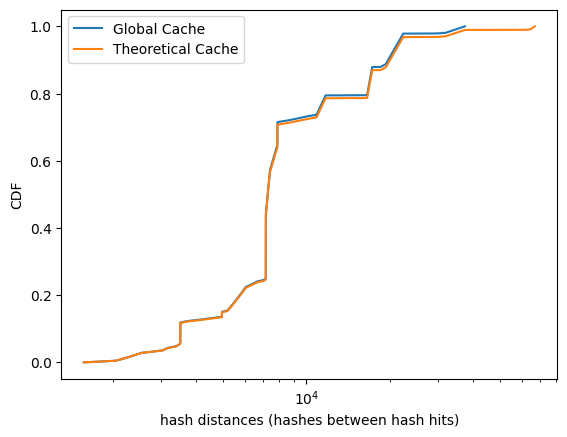

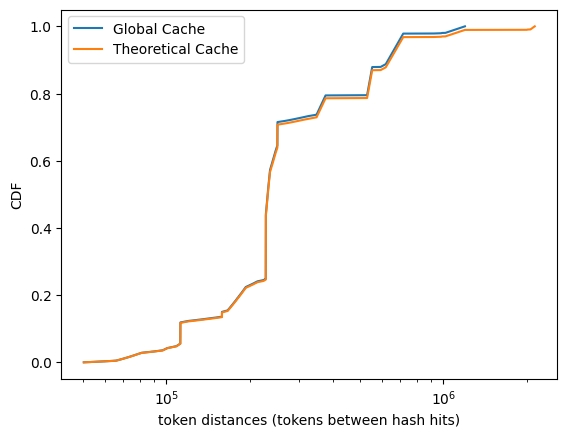

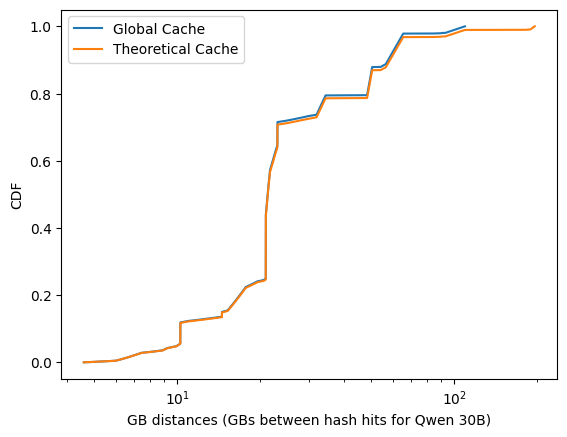

In [320]:
# Plot CDF for hash distances, token distances, and GB distances

from matplotlib import pyplot as plt
import numpy as np

hash_distances = np.sort(np.array(global_chunk_cache.hash_distances))
theoretical_hash_distances = np.sort(np.array(theoretical_chunk_cache.hash_distances))
token_distances = hash_distances * 32
theoretical_token_distances = theoretical_hash_distances * 32
gb_distances = token_distances * GB_per_tok
theoretical_gb_distances = theoretical_token_distances * GB_per_tok

# plot the CDF of the hash distances
plt.plot(*get_cdf_xy(hash_distances))
plt.plot(*get_cdf_xy(theoretical_hash_distances))
plt.xlabel("hash distances (hashes between hash hits)")
plt.ylabel("CDF")
plt.xscale("log")
plt.legend(["Global Cache", "Theoretical Cache"])
plt.show()

# plot the CDF of the token distances
plt.plot(*get_cdf_xy(token_distances))
plt.plot(*get_cdf_xy(theoretical_token_distances))
plt.xlabel("token distances (tokens between hash hits)")
plt.ylabel("CDF")
plt.xscale("log")
plt.legend(["Global Cache", "Theoretical Cache"])
plt.show()

# plot the CDF of the GB distances
plt.plot(*get_cdf_xy(gb_distances)) 
plt.plot(*get_cdf_xy(theoretical_gb_distances))
plt.xlabel("GB distances (GBs between hash hits for Qwen 30B)")
plt.ylabel("CDF")
plt.xscale("log")
plt.legend(["Global Cache", "Theoretical Cache"])
plt.show()


In [321]:
# Calculate the percentage of reuse that can be captured with the given cache size
theoretical_gb_distances = np.array(theoretical_chunk_cache.hash_distances) * toks_per_hash * GB_per_tok

# Find what percentage of hash hits have a distance <= cache_GB
hits_within_cache = np.sum(theoretical_gb_distances <= cache_GB)
total_hits = len(theoretical_gb_distances)
percentage_reuse = (hits_within_cache / total_hits) * 100

print(f"With a cache size of {cache_GB} GB, you will be able to achieve {percentage_reuse:.2f}% of the total theoretical reuse")
print(f"If your cache size is for vllm, you should aim for <10% theoretical reuse")
print(f"If your cache size is for LMCache, you should aim for >90% theoretical reuse")


With a cache size of 80 GB, you will be able to achieve 96.79% of the total theoretical reuse
If your cache size is for vllm, you should aim for <10% theoretical reuse
If your cache size is for LMCache, you should aim for >90% theoretical reuse
